In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geohash

In [2]:
featuredDataset = pd.read_csv('featured-dataset.csv').sample(5000)
featuredDataset = featuredDataset.drop(featuredDataset.columns[0], axis=1)
featuredDataset.head(5)

,year,month,day,time_cat,time_num,time_cos,time_sin,day_cat,day_num,day_cos,...,z_start,location_start,location_end,linea_org,tipo_usuario,ruta_org,viaje_org,coche_org,nodo_org,nodo_dest
60694,2022,11,19,17.366666666666667:22.0,0.759722,0.061049,-0.998135,Saturday,0.822817,0.441730,...,-0.493900,eztr28sn,eztr0nfp,2,17,2,22,22,423,338
72801,2022,11,23,8.133333333333333:8.0,0.365278,-0.662620,0.748956,Wednesday,0.337897,-0.524623,...,-0.493624,eztr38u2,eztr28mx,1,72,1,2,2,261,155
37897,2022,11,15,7.166666666666667:10.0,0.326389,-0.461749,0.887011,Tuesday,0.189484,0.371136,...,-0.510044,eztr0m6c,eztr3056,8,12,1,2,2,305,43
92093,2022,11,27,12.633333333333333:38.0,0.573611,-0.894934,-0.446198,Sunday,0.939087,0.927650,...,-0.481999,eztr3g0t,eztr322c,2,1,2,6,6,511,12
8107,2022,11,8,10.516666666666667:31.0,0.480556,-0.992546,0.121869,Tuesday,0.211508,0.239502,...,-0.499378,eztr0ze9,eztr0ry9,8,2,2,5,5,45,3


In [3]:
featuredDataset.shape

(5000, 24)

### Feature extraction

In [4]:

# Get the longitude and latitude from the geohash
def decodegeo(geo, which):
    if len(geo) >= 6:
        geodecoded = geohash.decode(geo)
        return geodecoded[which]
    else:
        return 0
    
def further_data_prep(df):  

    df['start_lat'] = df['location_start'].apply(lambda geo: decodegeo(geo, 0))
    df['start_lon'] = df['location_start'].apply(lambda geo: decodegeo(geo, 1))
    df['end_lat'] = df['location_end'].apply(lambda geo: decodegeo(geo, 0))
    df['end_lon'] = df['location_end'].apply(lambda geo: decodegeo(geo, 1))
    
    return df

In [5]:
featuredDataset = further_data_prep(featuredDataset)
featuredDataset.head(5)
featuredDataset.columns

Index(['year', 'month', 'day', 'time_cat', 'time_num', 'time_cos', 'time_sin',
       'day_cat', 'day_num', 'day_cos', 'day_sin', 'weekend', 'x_start',
       'y_start', 'z_start', 'location_start', 'location_end', 'linea_org',
       'tipo_usuario', 'ruta_org', 'viaje_org', 'coche_org', 'nodo_org',
       'nodo_dest', 'start_lat', 'start_lon', 'end_lat', 'end_lon'],
      dtype='object')

### Train-test split
For Cross Validation, we split the data into 80% train set and 20% test set.

In [6]:
columns_all_features = featuredDataset.columns
columns_X = ['day_num', 'x_start', 'y_start', 'z_start','linea_org','tipo_usuario','viaje_org', 'coche_org','ruta_org','time_num']
columns_y = ['end_lat', 'end_lon']
X = featuredDataset[columns_X]
y = featuredDataset[columns_y]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print ('X: ({}, {})'.format(*X.shape))
print ('y: ({}, {})'.format(*y.shape))
print ('X_train: ({}, {})'.format(*X_train.shape))
print ('y_train: ({}, {})'.format(*y_train.shape))
print ('X_test: ({}, {})'.format(*X_test.shape))
print ('y_test: ({}, {})'.format(*y_test.shape))

X: (5000, 10)
y: (5000, 2)
X_train: (4000, 10)
y_train: (4000, 2)
X_test: (1000, 10)
y_test: (1000, 2)


### Machine Learning

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#### Grid Search Cross Validation
Grid Search CV implements an exhaustive search over specified parameter values for an estimator.
Important members are fit, predict.

It iterates through a dictionary of hyper parameters and choose the combination that better fits the model.

In [24]:
from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [100,150,200,250,300], 'max_depth': [None, 1, 2, 3, 4,5,6], 'min_samples_split': [10,15,20,12]}


# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
gridCV = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, n_jobs=-1, verbose=1)
gridCV.fit(X_train, y_train)
print (gridCV.best_estimator_)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
RandomForestRegressor(min_samples_split=12, n_estimators=250)


#### Model accuracy: R-Squared and Root-mean-squared deviation
R-squared is a statistical measure of how close the data are to the fitted regression line. It ranges from 0 to 1, being 1 the best coefficient.
RMSE is the square root of the mean square error. In other worids the distance, on average, of a data point from the fitted line, measured along a vertical line.

In [26]:
reg = gridCV.best_estimator_
training_accuracy = reg.score(X_train, y_train)
valid_accuracy = reg.score(X_test, y_test)
rmsetrain = np.sqrt(mean_squared_error(reg.predict(X_train),y_train))
rmsevalid = np.sqrt(mean_squared_error(reg.predict(X_test),y_test))
print (" R^2 (train) = %0.6f, R^2 (valid) = %0.6f, RMSE (train) = %0.6f, RMSE (valid) = %0.6f" % (training_accuracy, valid_accuracy, rmsetrain, rmsevalid))

 R^2 (train) = 0.736286, R^2 (valid) = 0.394314, RMSE (train) = 0.007892, RMSE (valid) = 0.012505


#### Forest feature importances
Feature importance shows a coefficient of how much a feature is involved in the decision process of the model. It help us to detect bias in the model, and to make a readjust and better feature selection 

Feature ranking:
1. feature 5 (0.216750)
2. feature 3 (0.197595)
3. feature 8 (0.145890)
4. feature 9 (0.092050)
5. feature 0 (0.091104)
6. feature 1 (0.086868)
7. feature 2 (0.083828)
8. feature 4 (0.043987)
9. feature 7 (0.021023)
10. feature 6 (0.020904)


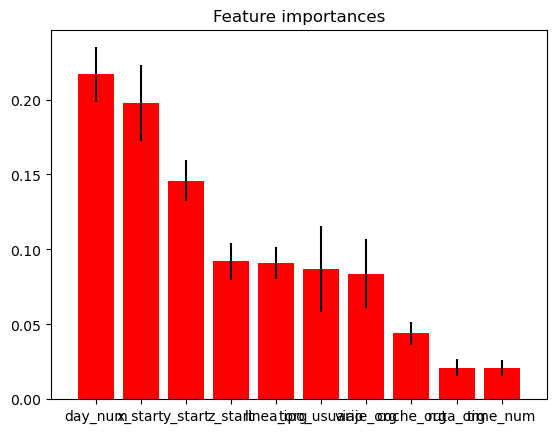

In [12]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
feature_names = X_train.columns
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [13]:
sampleds = pd.DataFrame(featuredDataset, columns=(columns_X + columns_y))
sampleds = sampleds.sample(10)
sampleds

,day_num,x_start,y_start,z_start,linea_org,tipo_usuario,viaje_org,coche_org,ruta_org,time_num,end_lat,end_lon
48054,0.381944,-0.668593,0.550437,-0.500003,2,100,0,0,0,0.673611,43.466120,-3.795605
30537,0.818849,-0.654543,0.553419,-0.515073,2,12,2,2,1,0.731944,43.447065,-3.852253
76642,0.375794,-0.686874,0.531709,-0.495469,8,1,8,8,2,0.630556,43.459425,-3.854313
75166,0.360516,-0.672777,0.546842,-0.498331,16,3,7,7,1,0.523611,43.463545,-3.802128
24349,0.632143,-0.656821,0.571741,-0.491629,19,17,6,6,2,0.425000,43.460798,-3.847103
63091,0.060317,-0.655553,0.566526,-0.499297,2,1,3,3,1,0.422222,43.463717,-3.811398
85699,0.641667,-0.663753,0.557134,-0.499033,2,1,5,5,1,0.491667,43.459425,-3.829250
48742,0.409921,-0.701051,0.521005,-0.486910,2,1,14,14,2,0.869444,43.463545,-3.802128
66875,0.195040,-0.657646,0.561823,-0.501853,2,72,3,3,1,0.365278,43.463888,-3.800411
67406,0.196825,-0.698587,0.528946,-0.481863,1,13,3,3,2,0.377778,43.465261,-3.787022


In [14]:
y_pred = reg.predict(sampleds.iloc[:,:-2])
y_pred

array([[43.46650176, -3.80683198],
       [43.45863401, -3.8222631 ],
       [43.45959107, -3.84246309],
       [43.46467016, -3.81076443],
       [43.46131708, -3.83241881],
       [43.46364221, -3.81096572],
       [43.46302969, -3.8117162 ],
       [43.46440677, -3.80424157],
       [43.46501079, -3.80698237],
       [43.46620118, -3.79786819]])

### Save the model
We dump the trained model into a file, so that we can later load and use it without having to fit it again

In [15]:
import joblib
joblib.dump(reg, 'random_forest_model.pkl') 

['random_forest_model.pkl']